# 프로젝트 : CutMix 또는 Mixup 비교실험하기

## Step 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
# 필요한 모듈 Import
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 불러오기
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


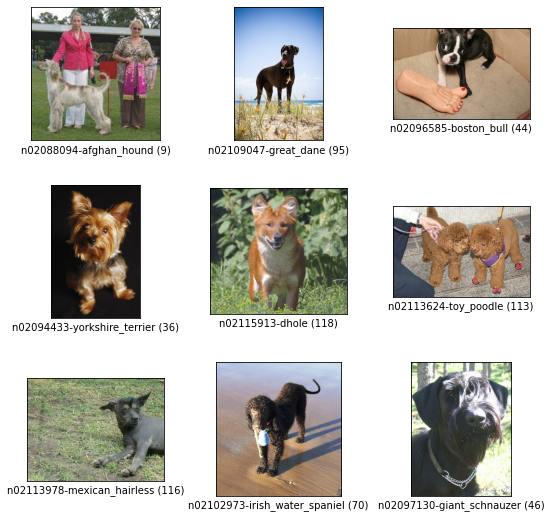

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

In [44]:
# 필요한 함수 만들기
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [26]:
# cumix와 관련되어서 필요한 함수 만들기
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
# Mixup과 관련되어 필요한 함수 만들기
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [46]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []
    
    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))
    
    imgs = tf.reshape(tf.stack(imgs), (batch_size, img_size, img_size, 3))
    return imgs, labels

## Step 2. 모델 만들기

In [7]:
num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [8]:
# augmentation 적용
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [47]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug = True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug = True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## Step 3. 모델 훈련하기

In [48]:
tf.random.set_seed(2020)

In [49]:
resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

history_resnet50 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
  2/750 [..............................] - ETA: 54s - loss: 5.4817 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0544s vs `on_train_batch_end` time: 0.0913s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2181 - accuracy: 0.4455WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0070s vs `on_test_batch_end` time: 0.0292s). Check your callbacks.


750/750 [==============================] - 114s 152ms/step - loss: 2.2181 - accuracy: 0.4455 - val_loss: 3.5526 - val_accuracy: 0.1809
Epoch 2/10
750/750 [==============================] - 114s 152ms/step - loss: 0.7641 - accuracy: 0.7859 - val_loss: 1.0771 - val_accuracy: 0.6830
Epoch 3/10
750/750 [==============================] - 117s 156ms/step - loss: 0.2644 - accuracy: 0.9402 - val_loss: 1.0682 - val_accuracy: 0.6944
Epoch 4/10
750/750 [==============================] - 113s 151ms/step - loss: 0.1109 - accuracy: 0.9850 - val_loss: 0.9553 - val_accuracy: 0.7198
Epoch 5/10
750/750 [==============================] - 114s 152ms/step - loss: 0.0449 - accuracy: 0.9970 - val_loss: 0.9233 - val_accuracy: 0.7423
Epoch 6/10
750/750 [==============================] - 114s 152ms/step - loss: 0.0225 - accuracy: 0.9983 - val_loss: 0.9414 - val_accuracy: 0.7381
Epoch 7/10
750/750 [==============================] - 114s 152ms/step - loss: 0.0196 - accuracy: 0.9985 - val_loss: 0.9868 - val_accura

In [50]:
aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)


history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:28 - loss: 5.3341 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0487s vs `on_train_batch_end` time: 0.0937s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2581 - accuracy: 0.4260WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0071s vs `on_test_batch_end` time: 0.0365s). Check your callbacks.


750/750 [==============================] - 124s 165ms/step - loss: 2.2581 - accuracy: 0.4260 - val_loss: 3.0657 - val_accuracy: 0.2617
Epoch 2/10
750/750 [==============================] - 136s 181ms/step - loss: 0.9377 - accuracy: 0.7268 - val_loss: 1.5451 - val_accuracy: 0.5742
Epoch 3/10
750/750 [==============================] - 143s 190ms/step - loss: 0.4947 - accuracy: 0.8629 - val_loss: 1.1417 - val_accuracy: 0.6679
Epoch 4/10
750/750 [==============================] - 123s 164ms/step - loss: 0.2673 - accuracy: 0.9327 - val_loss: 1.0717 - val_accuracy: 0.6952
Epoch 5/10
750/750 [==============================] - 139s 185ms/step - loss: 0.1369 - accuracy: 0.9739 - val_loss: 1.0378 - val_accuracy: 0.7071
Epoch 6/10
750/750 [==============================] - 121s 161ms/step - loss: 0.0897 - accuracy: 0.9850 - val_loss: 1.0741 - val_accuracy: 0.7088
Epoch 7/10
750/750 [==============================] - 117s 156ms/step - loss: 0.0590 - accuracy: 0.9926 - val_loss: 0.9813 - val_accura

In [ ]:
cutmix_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)


history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:50 - loss: 5.3406 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0614s vs `on_train_batch_end` time: 0.1101s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8324 - accuracy: 0.2086WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0069s vs `on_test_batch_end` time: 0.0384s). Check your callbacks.


750/750 [==============================] - 121s 162ms/step - loss: 3.8324 - accuracy: 0.2086 - val_loss: 3.2625 - val_accuracy: 0.2247
Epoch 2/10
750/750 [==============================] - 117s 155ms/step - loss: 2.9781 - accuracy: 0.4121 - val_loss: 1.6900 - val_accuracy: 0.5338
Epoch 3/10
750/750 [==============================] - 115s 154ms/step - loss: 2.7169 - accuracy: 0.5006 - val_loss: 1.5012 - val_accuracy: 0.5906
Epoch 4/10
750/750 [==============================] - 119s 159ms/step - loss: 2.5381 - accuracy: 0.5493 - val_loss: 1.4777 - val_accuracy: 0.5917
Epoch 5/10
750/750 [==============================] - 135s 179ms/step - loss: 2.3903 - accuracy: 0.5952 - val_loss: 1.1151 - val_accuracy: 0.6894
Epoch 6/10
750/750 [==============================] - 130s 173ms/step - loss: 2.3071 - accuracy: 0.6242 - val_loss: 1.1219 - val_accuracy: 0.6884
Epoch 7/10
750/750 [==============================] - 115s 153ms/step - loss: 2.2297 - accuracy: 0.6430 - val_loss: 1.1076 - val_accura

In [ ]:
mixup_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)


history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

## Step 4. 훈련 과정 시각화하기

### Augmentation에 의한 모델 성능 비교

In [ ]:
plt.figure(figsize = (12, 10))

plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'y')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')

plt.title("Model Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['No Augmentation', 'With Augmentation', 'Augmentation + Cutmix', 'Augmentation + Mixup'], loc = 'upper left')
plt.grid(True)
plt.ylim(0.7, 1.0)

plt.show()